In [1]:
import pandas as pd
import numpy as np

import torch

import torch.autograd as autograd
from torch.autograd import Variable

from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from collections import Counter
import matplotlib.pyplot as plt 
from IPython.display import Image

from scipy.interpolate import make_interp_spline, BSpline


In [2]:
#Helper functions

def split(word):
    return [char for char in word]
    
def padding(word):
    while len(word)<100:
        word = word + '\0'
    return word
    
def one_hot_encoding(data):
    mapped={'a':0,'b':1,'c':2,'\0':3}
    onehot_encoded = list()
    for element in data:
        letter = [0,0,0,0]
        letter[mapped[element]] = 1
        onehot_encoded.append(letter)
    return onehot_encoded
    

def hot_encode(padded_words):
    encoded_words=[]
    for word in padded_words:
        encoded_words.append(torch.tensor(one_hot_encoding(word)))
    return encoded_words    
        
def count(words):
    counts=[]
    for e in words:
        counts.append(torch.tensor(list(Counter(e).values())))
    return counts

In [3]:
class Preprocessing:
    def __init__(self):
        self.data = 'cfg_dataset.csv'
        self.max_len = 100
        self.tokens=[]
        self.words=[]
        self.padded=[]
        self.labels=[]
        self.sequ=[]
        
        self.load_data()
        self.add_padding()
        self.tokenize()
        self.token_to_seq()
        
    def load_data(self):
        df = pd.read_csv('cfg_dataset.csv')
        self.labels =df['Class'].values
        self.words = df['Words'].values
        
    def tokenize(self): #splitting words into lists of characters
        for e in self.padded:
            self.tokens.append(split(e))
 


#     def token_to_seq(self):   # replacing each token with an integer representation
#         for i in range(len(self.tokens)):
#             tmp=[]
#             for e in self.tokens[i]:
#                 if e =='a' :
#                     tmp.append(25)
#                 elif e=='b':
#                     tmp.append(50)
#                 elif e=='c':
#                     tmp.append(75)
#                 else:
#                     tmp.append(0)
#             self.sequ.append(tmp)



    def token_to_seq(self):   #replacing each token with it's ASCII code
        for e in self.tokens:
            self.sequ.append([ord(a) for a in e])
    
    def add_padding(self):  #Adds padding to each word to reach a length of 100
        for e in self.words:
            self.padded.append(padding(e))
            




In [4]:
from torch.utils.data import Dataset

class MyDataset(Dataset):  #Creating a dataset class inheriting from torch Dataset which will allow the use of the torch dataloader
    def __init__(self,data):
        self.data=data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        word_seq,class_nbr = self.data[idx]
#         class_nbr=torch.tensor(class_nbr)
        word_tensor=torch.tensor(word_seq)
        return word_tensor, class_nbr
    
    def __str__(self):
        return 'Custom dataset containing cfg words and their classes \n'+ 'Contains '+ str(len(self.data))+ ' words'
        

In [5]:
data=Preprocessing()

In [6]:
data_temp=list(zip(data.sequ,data.labels))

In [7]:
dataset = MyDataset(data_temp)
print(dataset)

Custom dataset containing cfg words and their classes 
Contains 700 words


In [8]:
dataset[0]

(tensor([97, 97, 97, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
         99, 99, 99, 99,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 0)

In [13]:
dataset[500]

(tensor([97, 97, 97, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 1)

In [14]:
train_dataset, test_dataset = random_split(dataset,[550, 150])
batch_size=32
train_loader=DataLoader(train_dataset, batch_size, shuffle= True)
test_loader= DataLoader(test_dataset, batch_size)

In [15]:
class LSTMClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_dim = 128
        self.LSTM_Layers = 2
        self.input_size = 100
        
        self.embedding = nn.Embedding(self.input_size, self.hidden_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.LSTM_Layers, batch_first=True)
        self.fc1 = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim*2)
        self.fc2 = nn.Linear(self.hidden_dim*2, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        
        h = torch.zeros((self.LSTM_Layers, x.size(0), self.hidden_dim))
        c = torch.zeros((self.LSTM_Layers, x.size(0), self.hidden_dim))
        
        torch.nn.init.xavier_normal_(h)
        torch.nn.init.xavier_normal_(c)

        out = self.embedding(x)
        out, (hidden, cell) = self.lstm(out, (h,c))
        out = self.dropout(out)
        out = torch.relu_(self.fc1(out[:,-1,:]))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))

        return out  
    
    def infer(self,batch):
        seq,label = batch
        seq = seq.type(torch.LongTensor)
        label = label.type(torch.FloatTensor)
        label= label.unsqueeze(1)
        out = self.forward(seq)
        loss=F.binary_cross_entropy(out,label)
        acc = accuracy(label,out)           
        return loss,acc
        
        
    

            

In [16]:
    def accuracy(grand_truth, predictions):
        true_positives = 0
        true_negatives = 0
        for true, pred in zip(grand_truth, predictions):
            if (pred > 0.5) and (true == 1):
                true_positives += 1
            elif (pred < 0.5) and (true == 0):
                true_negatives += 1
            else:
                pass
        return (true_positives+true_negatives) / len(grand_truth)

### Training and test

In [17]:
def fit(epochs, lr, model, train_loader,batch):      
    optimizer=optim.RMSprop(model.parameters(), lr)  
    train_History=[]
    for epoch in range(epochs):
        batch_train_losses=[]
        batch_train_accs=[] 
        for batch in train_loader:        
            loss,acc=model.infer(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_train_losses.append(loss)
            batch_train_accs.append(acc)
        epoch_train_acc = sum((batch_train_accs)) / float(len((batch_train_accs)))
        epoch_train_loss = torch.stack(batch_train_losses).mean()   
        train_History.append([epoch_train_loss,epoch_train_acc])
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(epoch, epoch_train_loss, epoch_train_acc))
    return train_History
            

In [18]:
def test(model, test_loader):
    test_History=[]
    batch_test_losses=[]
    batch_test_accs=[] 
    for batch in test_loader:        
        loss,acc=model.infer(batch)
        batch_test_losses.append(loss)
        batch_test_accs.append(acc)
    test_acc = sum((batch_test_accs)) / float(len((batch_test_accs)))
    test_loss = torch.stack(batch_test_losses).mean()
    print(" test_loss: {:.4f}, test_acc: {:.4f}".format( test_loss, test_acc))
    return test_acc,test_loss
    

In [14]:
del model

NameError: name 'model' is not defined

In [19]:
model=LSTMClassifier()

In [20]:
History=fit(15,0.001,model, train_loader,batch_size)

Epoch [0], train_loss: 0.7658, train_acc: 0.5683
Epoch [1], train_loss: 0.5913, train_acc: 0.6562
Epoch [2], train_loss: 0.5469, train_acc: 0.7512
Epoch [3], train_loss: 0.2900, train_acc: 0.9057
Epoch [4], train_loss: 0.1972, train_acc: 0.9456
Epoch [5], train_loss: 0.1687, train_acc: 0.9531
Epoch [6], train_loss: 0.1806, train_acc: 0.9456
Epoch [7], train_loss: 0.1640, train_acc: 0.9531
Epoch [8], train_loss: 0.1660, train_acc: 0.9531
Epoch [9], train_loss: 0.1854, train_acc: 0.9456
Epoch [10], train_loss: 0.1628, train_acc: 0.9531
Epoch [11], train_loss: 0.1741, train_acc: 0.9456
Epoch [12], train_loss: 0.1693, train_acc: 0.9531
Epoch [13], train_loss: 0.1865, train_acc: 0.9439
Epoch [14], train_loss: 0.1603, train_acc: 0.9549


In [21]:
Loss =[torch.detach(f_elemnt[0]).numpy() for f_elemnt in History]
Acc = [s_elemnt[1] for s_elemnt in History]

Training loss

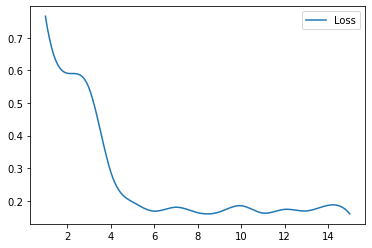

In [22]:

X=np.linspace(1, 15, 15).astype(int)
Y=Loss

xnew = np.linspace(X.min(), X.max(),150) 
spl = make_interp_spline(X, Y, k=3)  # type: BSpline
power_smooth = spl(xnew)


plt.plot(xnew, power_smooth,label='Loss')
plt.legend(loc="upper right")
plt.show()

Training Acc

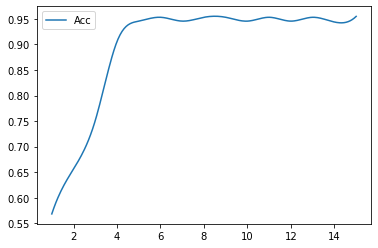

In [23]:
Y=Acc

xnew = np.linspace(X.min(), X.max(),300) 
spl = make_interp_spline(X, Y, k=3)  # type: BSpline
power_smooth = spl(xnew)


plt.plot(xnew, power_smooth,label='Acc')
plt.legend(loc="upper left")
plt.show()

In [24]:
metrics= test(model, test_loader)

 test_loss: 0.1715, test_acc: 0.9472


In [27]:
torch.save(model.state_dict(), 'cfg_lstm.pth')